# EnvisionBOX Summer School 2025, Day 4: Bringing all together
## Adding acoustics

In [11]:
import os
import glob
import numpy as np
import pandas as pd

curfolder = os.getcwd()

# here is where our data live
datafolder = os.path.join(curfolder, '..', 'Sample')

# get all avi files
mp4files = glob.glob(os.path.join(datafolder, '**', '*.mp4'), recursive=True)

# leave only those of femalemonologue
mp4files = [f for f in mp4files if 'femalemonologue' in f]

# we need only one because all are the same
audiofile = mp4files[0]


## Extracting acoustics from mp4 file - using moviepy

In [2]:
from moviepy import VideoFileClip

def extract_audio_from_mp4(mp4_path, output_wav_path):
    video = VideoFileClip(mp4_path)
    audio = video.audio
    audio.write_audiofile(output_wav_path, codec='pcm_s16le')  # WAV codec

#wavfile path will be in folder audio in this folder
if not os.path.exists('audio'):
    os.makedirs('audio')
wavfile = os.path.join('audio', os.path.basename(audiofile).replace('.mp4', '.wav'))
extract_audio_from_mp4(audiofile, wavfile)


MoviePy - Writing audio in audio\femalemonologue2_t3-cam01.wav


MoviePy - Done.


## Extracting envelope from audio signal

Now we have a folder with a number of audio files - either recorded with a microphone (preferred) or extracted from a video file. We can now extract the envelope of the audio signal, which is a smooth curve that represents the amplitude of the audio signal over time.

In [3]:
actotrack = glob.glob(os.path.join('audio', '*.wav'))

What is the sampling rate?

In [ ]:
from scipy.io import wavfile

sampling_rate, data = wavfile.read(actotrack[0])
print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 44100 Hz


In [8]:
from scipy.signal import butter, filtfilt
import librosa

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None, mono=True)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

In [14]:
# create folder where we store the processed data
if not os.path.exists('processedAudio'):
    os.makedirs('processedAudio')
ACfolder_processed = os.path.join(curfolder, 'processedAudio')

# Loop over wav files
for audiofile in actotrack:

    print('working on ' + audiofile)

    # get the basename
    id = os.path.basename(audiofile).replace('.wav', '')

    # apply the function
    ampv, sr = amp_envelope(audiofile)

    # Extract and plot the original signal
    rawaudio, sr = librosa.load(audiofile, sr=None)

    # create a time vector
    time_env = np.arange(0, len(rawaudio)/sr, 1/sr)
    
    # Ensure the lengths match by padding ampv if necessary (Note that is a quick fix)
    if len(ampv) < len(time_env):
        ampv = np.pad(ampv, (0, len(time_env) - len(ampv)), mode='constant')
    elif len(ampv) > len(time_env):
        ampv = ampv[:len(time_env)]

    # the same for rawaudio
    if len(rawaudio) < len(time_env):
        rawaudio = np.pad(rawaudio, (0, len(time_env) - len(rawaudio)), mode='constant')
    elif len(rawaudio) > len(time_env):
        rawaudio = rawaudio[:len(time_env)]
    
    # save the audio and envelope
    try:
        audio = pd.DataFrame({'time': time_env, 'audio': rawaudio, 'envelope': ampv, 'file': id})
        # convert time to ms
        audio['time'] = audio['time'] * 1000

        # perform also envelope change
        audio['envelope_change'] = np.insert(np.diff(audio['envelope']), 0, 0)
        # smooth
        audio['envelope_change'] = butter_lowpass_filtfilt(np.abs(audio['envelope_change']), 10, sr, order=2)
        
        # write as csv
        audio.to_csv(ACfolder_processed + '/env_' + id + '.csv', index=False)

    except ValueError:
        print('ValueError: ' + audiofile)
        continue

working on audio\femalemonologue2_t3-cam01.wav


This is how the dataframe looks like:

In [15]:
audio.head(50)

,time,audio,envelope,file,envelope_change
0,0.000000,0.002045,0.000000,femalemonologue2_t3-cam01,-0.000002
1,0.022676,0.002350,0.000020,femalemonologue2_t3-cam01,-0.000002
2,0.045351,0.002411,0.000040,femalemonologue2_t3-cam01,-0.000002
3,0.068027,0.003143,0.000059,femalemonologue2_t3-cam01,-0.000002
4,0.090703,0.003326,0.000079,femalemonologue2_t3-cam01,-0.000002
5,0.113379,0.003113,0.000099,femalemonologue2_t3-cam01,-0.000002
6,0.136054,0.003204,0.000119,femalemonologue2_t3-cam01,-0.000002
7,0.158730,0.003052,0.000139,femalemonologue2_t3-cam01,-0.000002
8,0.181406,0.002991,0.000159,femalemonologue2_t3-cam01,-0.000002
9,0.204082,0.002838,0.000178,femalemonologue2_t3-cam01,-0.000002


This is how the envelope signal looks like:

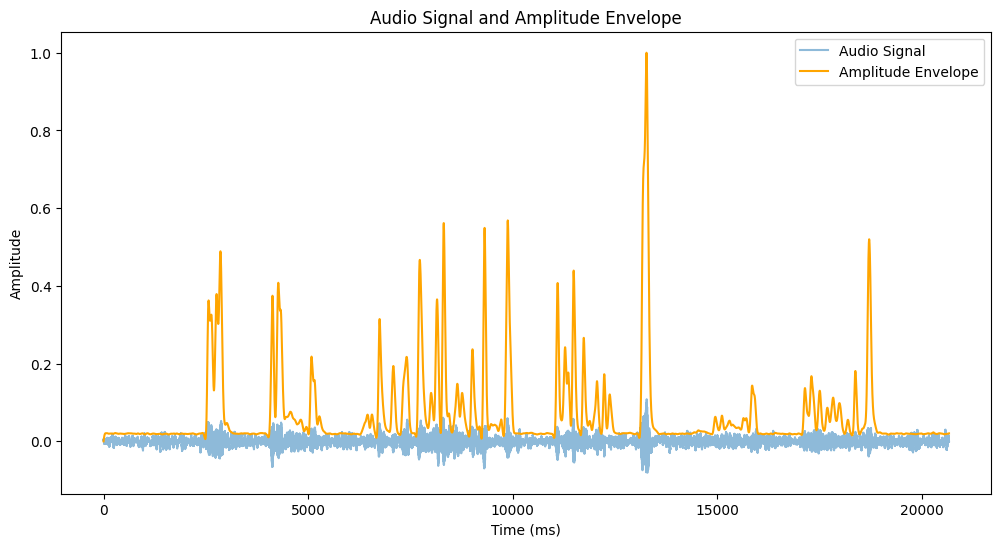

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(audio['time'], audio['audio'], label='Audio Signal', alpha=0.5)
plt.plot(audio['time'], audio['envelope'], label='Amplitude Envelope', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio Signal and Amplitude Envelope')
plt.legend()
plt.show()

